# ABOUT:
- In this notebook, I compare LightGCN, SAR and Popularity Recommenders on a Real-Life E-commerce Shopee user purchase data

In [2]:
from recommenders.models.sar import SAR
from recommenders.datasets.python_splitters import python_stratified_split
from recommenders.utils.constants import SEED as DEFAULT_SEED
from recommenders.evaluation.python_evaluation import precision_at_k
from recommenders.models.deeprec.DataModel.ImplicitCF import ImplicitCF
from recommenders.models.deeprec.deeprec_utils import prepare_hparams
from recommenders.models.deeprec.models.graphrec.lightgcn import LightGCN
from recommenders.utils.timer import Timer

import pandas as pd
import os

In [3]:
TOP_K = 10
MOVIELENS_DATA_SIZE = '100k'
EPOCHS = 40
BATCH_SIZE = 1024
SEED = DEFAULT_SEED  
COL_USER = "userID"   # "userID"
COL_ITEM = "itemID"
COL_RATING = "rating"
COL_TIMESTAMP = "timestamp"
MIN_INTERACTIONS = 2

yaml_file = r"C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\code1\config\lightgcn.yml"
# user_file = "../../tests/resources/deeprec/lightgcn/user_embeddings.csv"
# item_file = "../../tests/resources/deeprec/lightgcn/item_embeddings.csv"

### read and process data

In [4]:
directory = r"C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\data\shopee-20221117T041452Z-001\shopee"
os.chdir(directory)

In [5]:
df = pd.DataFrame()
usecols = ['Order ID', "Ship Time", "Username (Buyer)", "Product Name", "Deal Price", "Quantity", "Voucher Code", "Username (Buyer)", "Zip Code"]
for file in os.listdir(directory):
    if "Order" in file:
        tmp = pd.read_excel(file, usecols=usecols)
        df = pd.concat([df,tmp], axis = 0)
df.drop_duplicates(inplace = True)
df = df.reset_index(drop = True)

In [6]:
def process(dataframe):
    tmp = dataframe.groupby(["Product Name", "Username (Buyer)"]).count()
    tmp = pd.DataFrame(df.groupby(["Product Name", "Username (Buyer)"]).count()).reset_index()
    tmp = tmp[["Product Name", "Username (Buyer)", "Order ID"]] 
    tmp.columns = [COL_ITEM, COL_USER, COL_RATING]
    return tmp

In [7]:
shopee_df = process(df)

In [17]:
def clean(df, min_interactions, drop_cold_users = True, drop_cold_items = False):
    output_df = df.copy()
    
    # cleaning
    output_df = output_df.drop_duplicates(subset = [COL_USER, COL_ITEM])
    output_df[COL_RATING] = output_df[COL_RATING].apply(lambda rating: 1 if rating is None else rating)
    output_df[COL_RATING] = output_df[COL_RATING].astype(int)
    
    # find warm items and users
    item_counts = output_df[COL_ITEM].value_counts()
    warm_items = item_counts[item_counts>=min_interactions]
    user_counts = output_df[COL_USER].value_counts()
    warm_users = user_counts[user_counts>=min_interactions]
    
    # keep only warm items and users
    if drop_cold_users:
        output_df = output_df[output_df[COL_USER].isin(warm_users.index)]
    if drop_cold_items:
        output_df = output_df[output_df[COL_ITEM].isin(warm_items.index)]
            
    return output_df

In [22]:
shopee_df_reduced = clean(shopee_df, MIN_INTERACTIONS)

In [ ]:
shopee_df_reduced

In [25]:
print("""
    Reduced Data:
    Total Ratings: {train_total}
    Unique Users: {train_users}
    Unique Items: {train_items}

    Original Data:
    Total Ratings: {test_total}
    Unique Users: {test_users}
    Unique Items: {test_items}
    """.format(
        train_total=len(shopee_df_reduced),
        train_users=len(shopee_df_reduced[COL_USER].unique()),
        train_items=len(shopee_df_reduced[COL_ITEM].unique()),
        test_total=len(shopee_df),
        test_users=len(shopee_df[COL_USER].unique()),
        test_items=len(shopee_df[COL_ITEM].unique()),
))


    Reduced Data:
    Total Ratings: 1267
    Unique Users: 543
    Unique Items: 179

    Original Data:
    Total Ratings: 7044
    Unique Users: 6320
    Unique Items: 251
    


#### Train test split

In [26]:
train, test = python_stratified_split(shopee_df_reduced, ratio=0.8,
                                      min_rating=1, filter_by='user', 
                                      col_user=COL_USER, col_item=COL_ITEM, 
                                      seed=SEED)

In [27]:
print("""
Train:
Total Ratings: {train_total}
Unique Users: {train_users}
Unique Items: {train_items}

Test:
Total Ratings: {test_total}
Unique Users: {test_users}
Unique Items: {test_items}
""".format(
    train_total=len(train),
    train_users=len(train['userID'].unique()),
    train_items=len(train['itemID'].unique()),
    test_total=len(test),
    test_users=len(test['userID'].unique()),
    test_items=len(test['itemID'].unique()),
))


Train:
Total Ratings: 1146
Unique Users: 543
Unique Items: 172

Test:
Total Ratings: 121
Unique Users: 121
Unique Items: 66



## Train and Evaluate: SAR

In [53]:
# Similarity types: ["cooccurrence" | "cosine" | "inclusion index" | "jaccard" | "lift" | "mutual information" | "lexicographers mutual information"]
model_sar = SAR(
    col_user=COL_USER,
    col_item=COL_ITEM,
    col_rating=COL_RATING,
    col_timestamp=COL_TIMESTAMP,
    similarity_type="cooccurrence", 
    time_decay_coefficient=30, 
    timedecay_formula=False,
    normalize=False
)

In [54]:
model_sar.fit(train)

In [55]:
top_k = model_sar.recommend_k_items(test, top_k=TOP_K, remove_seen=False)
eval_precision = precision_at_k(test, top_k, col_user='userID', col_item='itemID', col_rating='rating', k=TOP_K)
eval_precision   

0.02644628099173554

## Train and Evaluate: Popularity Recommender

In [35]:
def construct_popular_predictions_table(test, model, top_k):
    user_ids = test.userID.unique()
    popular_items = model.get_popularity_based_topk(top_k = top_k)
    output = pd.DataFrame()
    for user_id in user_ids:
        popular_items["userID"] = user_id
        output = pd.concat([output, popular_items], axis = 0)
    return output

In [36]:
top_k = construct_popular_predictions_table(test = test, model = model_sar, top_k = TOP_K)
eval_precision = precision_at_k(test, top_k, col_user=COL_USER, col_item=COL_ITEM, col_rating=COL_RATING, k=TOP_K)
eval_precision  

0.02809917355371901

## Train and Evaluate: LightGCN

In [56]:
data = ImplicitCF(train = train, test=test, 
                  adj_dir=None, 
                  col_user=COL_USER, col_item=COL_ITEM, 
                  seed=SEED)

C:\Users\tanch\anaconda3\envs\fyp1\lib\site-packages\recommenders\models\deeprec\DataModel\ImplicitCF.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train if test is None else train.append(test)


In [90]:
loss_type = "AmpBPR2"
loss_type = "OriginalBPR"
loss_type = "AmpBPR2"

loss_neg_weight = 1.3
log_wandb = False

In [91]:
hparams = prepare_hparams(yaml_file,
                          n_layers=2,
                          loss_type = loss_type, 
                          loss_neg_weight = loss_neg_weight, 
                          log_wandb = log_wandb,
                          batch_size=BATCH_SIZE,
                          epochs=70,
                          learning_rate=0.005,
                          eval_epoch=1,
                          top_k=TOP_K,
                          COL_USER = COL_USER,
                          COL_ITEM = COL_ITEM,
                          COL_RATING = COL_RATING
                          )
# initiate model
model = LightGCN(hparams, data, seed=SEED)

Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.


In [92]:
model.fit()

Epoch 1 (train)0.2s + (eval)0.1s: train loss = 0.68425 = (mf)0.68422 + (embed)0.00004, precision = 0.01322
Epoch 2 (train)0.0s + (eval)0.0s: train loss = 0.67903 = (mf)0.67899 + (embed)0.00004, precision = 0.01240
Epoch 3 (train)0.0s + (eval)0.0s: train loss = 0.67332 = (mf)0.67328 + (embed)0.00004, precision = 0.01653
Epoch 4 (train)0.0s + (eval)0.0s: train loss = 0.66535 = (mf)0.66530 + (embed)0.00005, precision = 0.01983
Epoch 5 (train)0.0s + (eval)0.0s: train loss = 0.65758 = (mf)0.65752 + (embed)0.00005, precision = 0.01983
Epoch 6 (train)0.0s + (eval)0.0s: train loss = 0.64669 = (mf)0.64663 + (embed)0.00006, precision = 0.02149
Epoch 7 (train)0.0s + (eval)0.0s: train loss = 0.63397 = (mf)0.63391 + (embed)0.00006, precision = 0.02231
Epoch 8 (train)0.0s + (eval)0.0s: train loss = 0.62194 = (mf)0.62187 + (embed)0.00007, precision = 0.02314
Epoch 9 (train)0.0s + (eval)0.0s: train loss = 0.60526 = (mf)0.60518 + (embed)0.00008, precision = 0.02314
Epoch 10 (train)0.0s + (eval)0.0s: tr

## Comparison
- It is quite clear that when dataset is small, advanced recommenders like SAR and LightGCN cannot person
- target audience has to be e-commerce owners that are sufficiently large

In [93]:
import seaborn as sb

In [94]:
precison_tmp = {
    "LightGCN":0.03471,
    "SAR":0.026446,
    "Popularity":0.0281
}   

[Text(0.5, 0, 'Precision@10')]

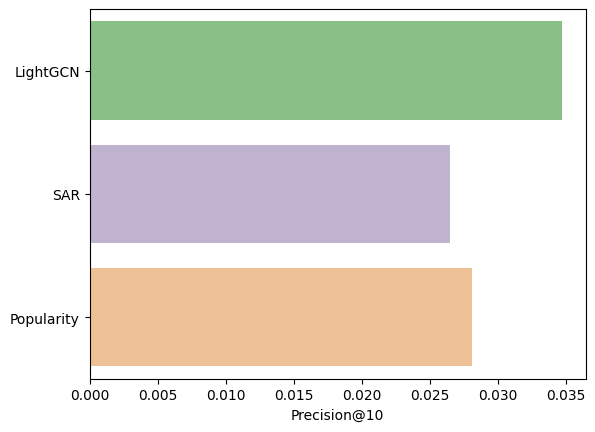

In [95]:
p = sb.barplot(x = list(precison_tmp.values()),y = list(precison_tmp.keys()), palette = "Accent")
p.set(xlabel = "Precision@10")